## Mark prediction for the students at the final exam in mathematics

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [4]:
import xgboost as xgb

In [5]:
%matplotlib inline

## Data preparation

In [6]:
df_students = pd.read_csv("student-mat.csv", sep =";")

In [7]:
df_students.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,14,15,15


Let's encode binary columns:

In [8]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns 

    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)    

In [9]:
df_students = MultiColumnLabelEncoder(columns = ['school','sex','address','famsize','Pstatus','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']).fit_transform(df_students)

Let's encode some columns using one-hot encoding:

In [10]:
mjob_columns = [
    "m_at_home",
    "m_health",
    "m_other",
    "m_services",
    "m_teacher"
]

fjob_columns = [
    "f_at_home",
    "f_health",
    "f_other",
    "f_services",
    "f_teacher"     
]

reason_columns = [
    "r_course",
    "r_home",
    "r_other",    
    "r_reputation"
]

guardian_columns = [
    "g_father",
    "g_mother",
    "g_other"
]

df_students[mjob_columns] = pd.get_dummies(df_students["Mjob"])
df_students[fjob_columns] = pd.get_dummies(df_students["Fjob"])
df_students[reason_columns] = pd.get_dummies(df_students["reason"])
df_students[guardian_columns] = pd.get_dummies(df_students["guardian"])

In [11]:
df_students.dtypes

school           int64
sex              int64
age              int64
address          int64
famsize          int64
Pstatus          int64
Medu             int64
Fedu             int64
Mjob            object
Fjob            object
reason          object
guardian        object
traveltime       int64
studytime        int64
failures         int64
schoolsup        int64
famsup           int64
paid             int64
activities       int64
nursery          int64
higher           int64
internet         int64
romantic         int64
famrel           int64
freetime         int64
goout            int64
Dalc             int64
Walc             int64
health           int64
absences         int64
G1               int64
G2               int64
G3               int64
m_at_home        uint8
m_health         uint8
m_other          uint8
m_services       uint8
m_teacher        uint8
f_at_home        uint8
f_health         uint8
f_other          uint8
f_services       uint8
f_teacher        uint8
r_course   

We will drop the initial columns to which we have applied one-hot encoding, as well as G1, G2, G3. We will predict G3:

In [38]:
df_X = df_students.drop(['Mjob','Fjob','reason','guardian','G1','G2','G3'], axis = 1)
df_y = df_students["G3"]

Let's convert DataFrames into NumPy arrays:

In [39]:
X = df_X.values
y = df_y.values
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (395, 43)
y shape: (395,)


Let's divide the data into a training and test sets in a proportion of 90%: 10%:

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=56)

In [41]:
print("X train", X_train.shape)
print("y train", y_train.shape)
print("X test", X_test.shape)
print("y test", y_test.shape)

X train (355, 43)
y train (355,)
X test (40, 43)
y test (40,)


## Modelling

For the training set, we will train the XGBRegressor of 200 trees with a maximum depth of 4 and learning rate 0.05. Also we will calculate the mean error prediction (MAE):

In [42]:
booster = xgb.XGBRegressor(
                max_depth = 4, n_estimators=200,
                learning_rate=0.05, seed=98, silent = True)
booster.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='mae')

[0]	validation_0-mae:9.62057	validation_1-mae:9.07605
[1]	validation_0-mae:9.1908	validation_1-mae:8.65949
[2]	validation_0-mae:8.77624	validation_1-mae:8.26465
[3]	validation_0-mae:8.38939	validation_1-mae:7.89216
[4]	validation_0-mae:8.02092	validation_1-mae:7.53434
[5]	validation_0-mae:7.6684	validation_1-mae:7.1862
[6]	validation_0-mae:7.3348	validation_1-mae:6.86251
[7]	validation_0-mae:7.0192	validation_1-mae:6.55111
[8]	validation_0-mae:6.72322	validation_1-mae:6.25916
[9]	validation_0-mae:6.43694	validation_1-mae:5.98006
[10]	validation_0-mae:6.16519	validation_1-mae:5.73752
[11]	validation_0-mae:5.90793	validation_1-mae:5.50038
[12]	validation_0-mae:5.66437	validation_1-mae:5.28412
[13]	validation_0-mae:5.43562	validation_1-mae:5.07033
[14]	validation_0-mae:5.21354	validation_1-mae:4.89488
[15]	validation_0-mae:5.01378	validation_1-mae:4.75069
[16]	validation_0-mae:4.82107	validation_1-mae:4.59373
[17]	validation_0-mae:4.64326	validation_1-mae:4.44958
[18]	validation_0-mae:4.4

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=98, silent=True, subsample=1)

So, the prediction error for 200 trees on the training and test samples:

In [54]:
print("MAE_train =", booster.evals_result()['validation_0']['mae'][-1])
print("MAE_test =", booster.evals_result()['validation_1']['mae'][-1])

MAE_train = 1.095075
MAE_test = 3.033574


Let's predict the value of y on the test set and plot the difference between predicted and true values:

In [48]:
y_pred = booster.predict(X_test)
df_residuals = pd.DataFrame(y_test - y_pred, columns=["residual"])

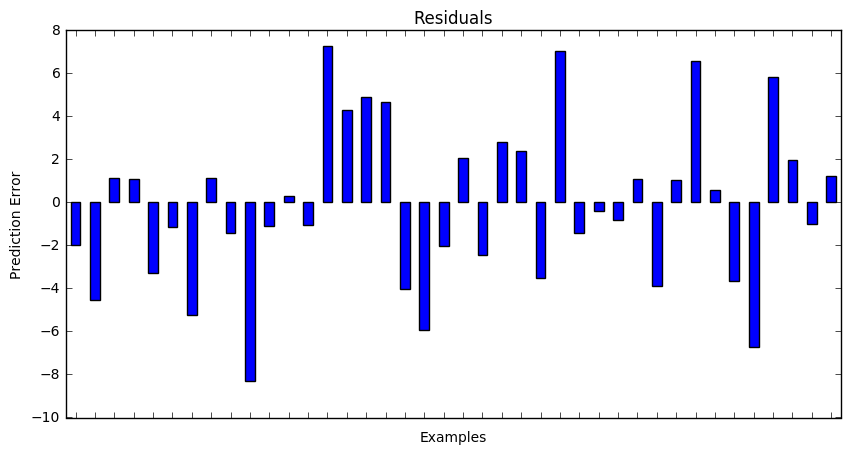

In [26]:
ax = df_residuals.plot.bar(figsize=(10, 5))
ax.legend().remove()
ax.get_xaxis().set(ticklabels=[])
ax.set(xlabel="Examples")
ax.set(ylabel="Prediction Error")
ax.set(title="Residuals")

## Evaluation of the feature importance

Let's define the numerical importance of the features and create the histogram of the feature importance:

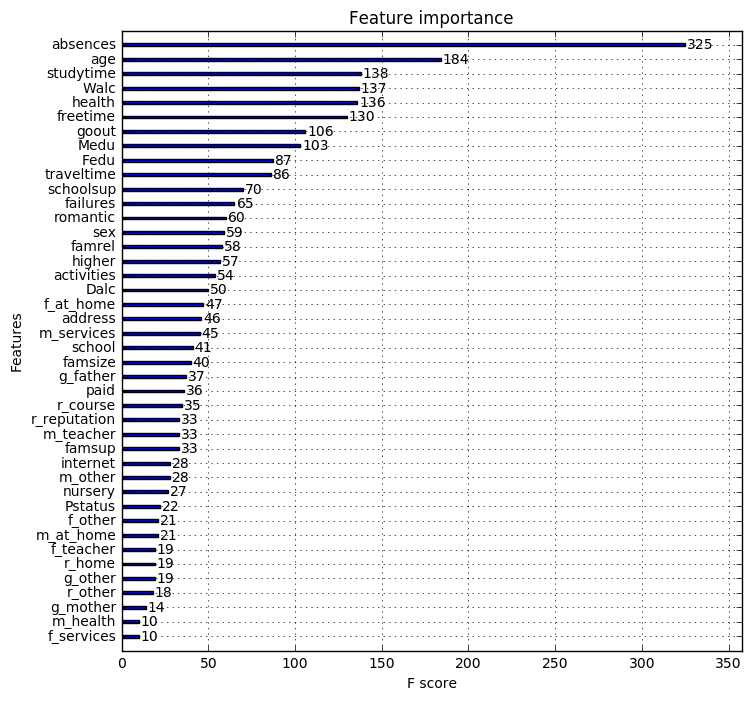

In [49]:
dtrain = xgb.DMatrix(df_X)

mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
mapped = {mapper[k]: v for k, v in booster.booster().get_fscore().items()}
plt.rcParams['figure.figsize'] = (8, 8)
xgb.plot_importance(mapped, color='blue')
plt.yticks(fontsize=10)   
plt.show()

Let's display 5 most important features and their importance:

In [63]:
df_features = pd.DataFrame([[col1,col2] for col1, col2 in mapped.items()], 
           columns=['feature','importance']).sort_values('importance', ascending=False)
print(df_features.head(5))

      feature  importance
21   absences         325
16        age         184
38  studytime         138
33       Walc         137
22     health         136


Thus, the most important features are the number of absences, age, study time, weekend alcohol consumption and current health status.

## Analysis of MAE

Let's train 300 trees:

In [29]:
booster_300 = xgb.XGBRegressor(
                max_depth = 4, n_estimators=300,
                learning_rate=0.05, seed=98, silent = False)
booster_300.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae')

[0]	validation_0-mae:9.07605
[1]	validation_0-mae:8.65949
[2]	validation_0-mae:8.26465
[3]	validation_0-mae:7.89216
[4]	validation_0-mae:7.53434
[5]	validation_0-mae:7.1862
[6]	validation_0-mae:6.86251
[7]	validation_0-mae:6.55111
[8]	validation_0-mae:6.25916
[9]	validation_0-mae:5.98006
[10]	validation_0-mae:5.73752
[11]	validation_0-mae:5.50038
[12]	validation_0-mae:5.28412
[13]	validation_0-mae:5.07033
[14]	validation_0-mae:4.89488
[15]	validation_0-mae:4.75069
[16]	validation_0-mae:4.59373
[17]	validation_0-mae:4.44958
[18]	validation_0-mae:4.30927
[19]	validation_0-mae:4.17565
[20]	validation_0-mae:4.08198
[21]	validation_0-mae:3.98506
[22]	validation_0-mae:3.89079
[23]	validation_0-mae:3.81517
[24]	validation_0-mae:3.72927
[25]	validation_0-mae:3.66854
[26]	validation_0-mae:3.60929
[27]	validation_0-mae:3.56025
[28]	validation_0-mae:3.51658
[29]	validation_0-mae:3.47112
[30]	validation_0-mae:3.43374
[31]	validation_0-mae:3.39504
[32]	validation_0-mae:3.36795
[33]	validation_0-mae

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=98, silent=False, subsample=1)

We will leave the MAE values for the number of trees in the range 10 - 300:

In [58]:
MAE = booster_300.evals_result()['validation_0']['mae'][9:]

We will create a graph of MAE dependence on the number of trees in the test sample:

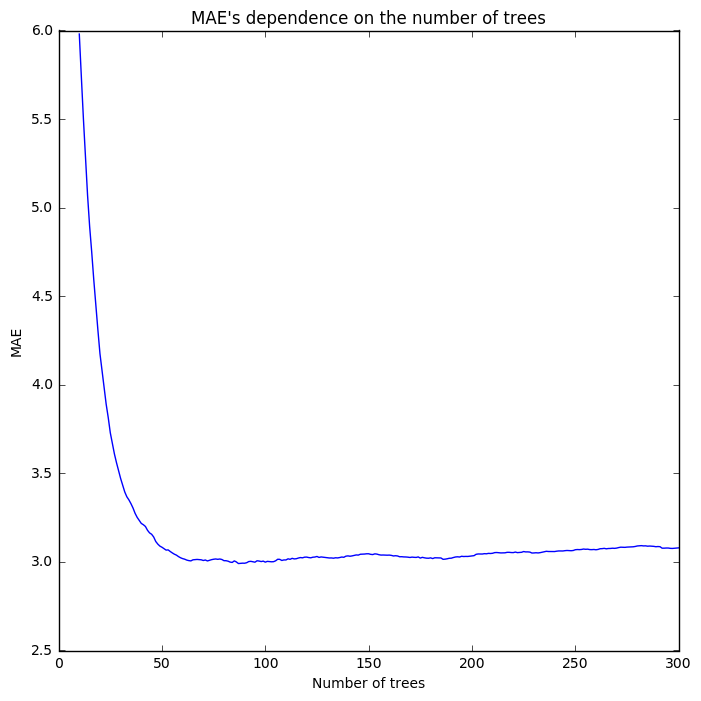

In [59]:
x = np.arange(10, 301, 1)
plt.plot(x, np.array(MAE))
plt.xlabel('Number of trees')
plt.ylabel('MAE')
plt.title("MAE's dependence on the number of trees")

So we can conclude that after a certain number of trees, the average prediction error ceases to decrease and almost does not change.